In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [4]:
multicore_out_path = "./results_multicore"
singlecore_out_path = "./results_singlecore"

trace_combination_filename = "multicore_traces.txt"

trace_combs = {}
with open(trace_combination_filename, "r") as trace_combination_file:
    for line in trace_combination_file:
        line = line.strip()
        if(line == ""):
            continue
        trace_name = line.split(",")[0]
        trace_list = line.split(",")[1:]
        trace_combs[trace_name] = trace_list

ipc_alone = {}

result_path = singlecore_out_path + "/NoDefense/cmd_count/"
result_list = [x[:-10] for x in os.listdir(result_path) if (x.endswith(".cmd.count") and x.startswith("100"))]
for result_filename in result_list:
    result_file = open(result_path + "/" + result_filename + ".cmd" + ".count", "r")
    trace = result_filename.split("_")[1]
    core_0 = 0
    for line in result_file.readlines():
        if ("ACT" in line):
            core_0 = int(line.split(", ")[-1])
    ipc_alone[trace] = core_0
    result_file.close()

df = pd.DataFrame(columns=["mitigation", "trh", "trace", "act"])
mitigation_list = ["PrIDE", "PrIDE+RFM16", "PrIDE+RFM40", "PrIDE+PRAC", "PrIDE+PRAC+RFM16", "PrIDE+PRAC+RFM40", "MINT", "MINT+RFM16", "MINT+RFM40", "MINT+PRAC", "MINT+PRAC+RFM16", "MINT+PRAC+RFM40", "PARA", "PARA+PRAC", "Hydra", "Hydra+PRAC", "TWiCe-Ideal", "TWiCe-Ideal+PRAC", "Graphene", "Graphene+PRAC", "OracleRH", "OracleRH+PRAC", "RRS", "RRS+PRAC", "NoDefense", "NoDefense+PRAC"]
for mitigation in mitigation_list:
    result_path = multicore_out_path + "/" + mitigation + "/cmd_count/"
    result_list = [x[:-10] for x in os.listdir(result_path) if x.endswith(".cmd.count")]
    for result_filename in result_list:
        result_file = open(result_path + "/" + result_filename + ".cmd" + ".count", "r")
        trh = int(result_filename.split("_")[0])
        trace = result_filename.split("_")[1]
        ipc_0 = 0
        ipc_1 = 0
        ipc_2 = 0
        ipc_3 = 0
        trace_0, trace_1, trace_2, trace_3 = trace_combs[trace]
        for line in result_file.readlines():
            if ("ACT" in line):
                ipc_0 = int(line.split(", ")[1])
        if (ipc_0 == 0 and ipc_1 == 0 and ipc_2 == 0 and ipc_3 == 0):
            continue
        
        Activation = ipc_0 + ipc_1 + ipc_2 + ipc_3
        result_file.close()

        new_row = pd.DataFrame([{'mitigation': mitigation, 'trh': trh, 'trace': trace, 'act': Activation}])
        df = pd.concat([df, new_row], ignore_index=True)

df = df.pivot(index=['trh', 'trace'], columns=['mitigation'], values='act').reset_index()
for mitigation in set(mitigation_list) - set(['NoDefense']):
    df[mitigation] = df[mitigation] / df['NoDefense']

df['NoDefense'] = 1
# df.drop(['NoDefense'], axis=1, inplace=True)
df.rename(columns={'OracleRH': 'Ideal'}, inplace=True)
df = df.melt(id_vars=['trh', 'trace'], var_name='mitigation', value_name='act')

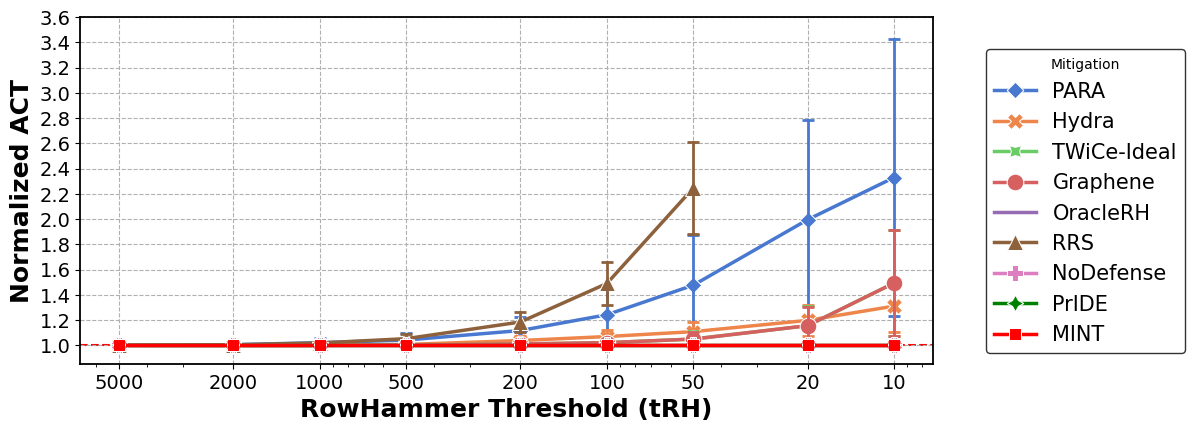

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# 선택할 항목 정의
selected_mitigations = ["PARA", "Hydra", "TWiCe-Ideal",  "Graphene", "OracleRH", "RRS",  "NoDefense", "PrIDE", "MINT"]

# 커스텀 색상 팔레트 정의
custom_palette = {
    "MINT": "red",
    "PrIDE": "green"
}

# 기본 팔레트 생성
default_palette = sns.color_palette("muted", len(selected_mitigations))

# 커스텀 색상 팔레트와 기본 팔레트 결합
final_palette = {mitigation: custom_palette.get(mitigation, default_palette[i]) for i, mitigation in enumerate(selected_mitigations)}

# 전체 그래프 크기 설정
fig, ax = plt.subplots(figsize=(11, 4.5))

# 선택한 항목만 필터링하여 꺾은선 그래프 그리기
sns.lineplot(
    x='trh', 
    y='act', 
    hue='mitigation', 
    data=df[df['mitigation'].isin(selected_mitigations)],  # 필터링된 데이터 사용
    ax=ax,
    linewidth=2.5,
    markers=True, 
    dashes=False, 
    style='mitigation', 
    markersize=12, 
    errorbar=("sd"), 
    err_style='bars',
    hue_order=selected_mitigations,  # 선택된 항목의 순서
    palette=final_palette, #커스텀 색상 팔레트 적용용
    err_kws={'capsize': 4, 'elinewidth': 2, 'capthick': 2}
)

# 그리드, 축 설정
plt.grid(axis='both', linestyle='--')
plt.gca().invert_xaxis()  # x축 반전
plt.xscale('log')

# x축, y축 레이블 및 눈금 설정
x_ticks = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, fontsize=14)

y_ticks = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6]
ax.axhline(y=1.0, color='red', linestyle='--', zorder=0)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=14)

ax.set_xlabel("RowHammer Threshold (tRH)", fontsize=18, weight="bold")
ax.set_ylabel("Normalized ACT", fontsize=18, weight="bold")

# 테두리 선 설정
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.3)

# 범례 위치 조정
plt.legend(title="Mitigation", loc='lower left', bbox_to_anchor=(1.05, 0), ncol=1, fontsize=15, edgecolor='black')

# 그래프 출력
plt.show()


In [3]:
multicore_out_path = "./result_single400_multi200/multicore_최종"
singlecore_out_path = "./result_single400_multi200/singlecore_최종"

trace_combination_filename = "multicore_traces.txt"

trace_combs = {}
with open(trace_combination_filename, "r") as trace_combination_file:
    for line in trace_combination_file:
        line = line.strip()
        if(line == ""):
            continue
        trace_name = line.split(",")[0]
        trace_list = line.split(",")[1:]
        trace_combs[trace_name] = trace_list

ipc_alone = {}

result_path = singlecore_out_path + "/NoDefense/cmd_count/"
result_list = [x[:-10] for x in os.listdir(result_path) if (x.endswith(".cmd.count") and x.startswith("400"))]
for result_filename in result_list:
    result_file = open(result_path + "/" + result_filename + ".cmd.count", "r")
    trace = result_filename.split("_")[1]
    core_0 = 0
    for line in result_file.readlines():
        if ("ACT" in line):
            core_0 = int(line.split(", ")[-1])
    ipc_alone[trace] = core_0
    result_file.close()

df = pd.DataFrame(columns=["mitigation", "trh", "trace", "act"])
mitigation_list = ["PrIDE", "PrIDE+RFM16", "PrIDE+RFM40", "PrIDE+PRAC", "PrIDE+PRAC+RFM16", "PrIDE+PRAC+RFM40", "MINT", "MINT+RFM16", "MINT+RFM40", "MINT+PRAC", "MINT+PRAC+RFM16", "MINT+PRAC+RFM40", "NoDefense"]
for mitigation in mitigation_list:
    result_path = multicore_out_path + "/" + mitigation + "/cmd_count/"
    result_list = [x[:-10] for x in os.listdir(result_path) if x.endswith(".cmd.count")]
    for result_filename in result_list:
        result_file = open(result_path + "/" + result_filename + ".cmd.count", "r")
        trh = int(result_filename.split("_")[0])
        trace = result_filename.split("_")[1]
        ipc_0 = 0
        ipc_1 = 0
        ipc_2 = 0
        ipc_3 = 0
        trace_0, trace_1, trace_2, trace_3 = trace_combs[trace]
        for line in result_file.readlines():
            if ("ACT" in line):
                ipc_0 = int(line.split(", ")[1])
        if (ipc_0 == 0 and ipc_1 == 0 and ipc_2 == 0 and ipc_3 == 0):
            continue
        
        Activation = ipc_0 + ipc_1 + ipc_2 + ipc_3
        result_file.close()

        new_row = pd.DataFrame([{'mitigation': mitigation, 'trh': trh, 'trace': trace, 'act': Activation}])
        df = pd.concat([df, new_row], ignore_index=True)

df = df.pivot(index=['trh', 'trace'], columns=['mitigation'], values='act').reset_index()
for mitigation in set(mitigation_list) - set(['NoDefense']):
    df[mitigation] = df[mitigation] / df['NoDefense']

df['NoDefense'] = 1
# df.drop(['NoDefense'], axis=1, inplace=True)
df.rename(columns={'OracleRH': 'Ideal'}, inplace=True)
df = df.melt(id_vars=['trh', 'trace'], var_name='mitigation', value_name='act')


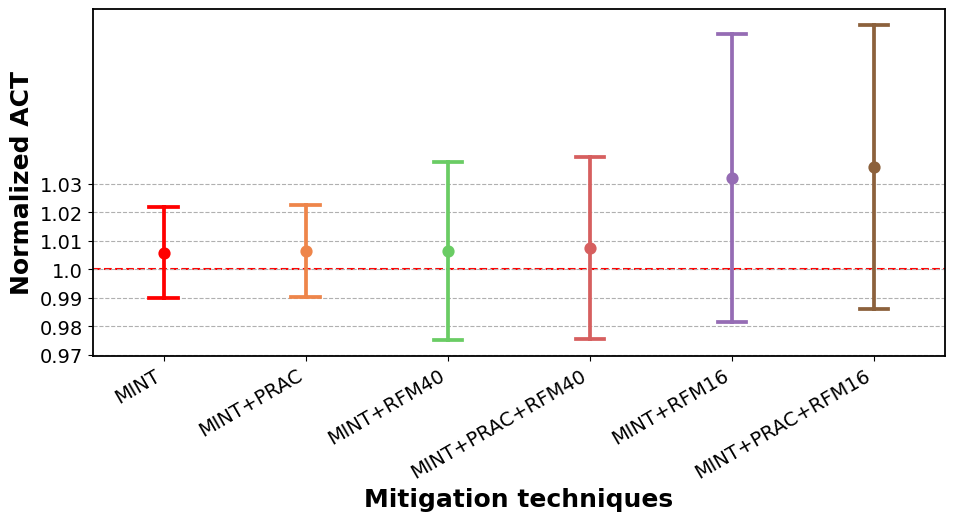

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 선택할 항목 정의
selected_mitigations = ["MINT", "MINT+PRAC", "MINT+RFM40", "MINT+PRAC+RFM40", "MINT+RFM16", "MINT+PRAC+RFM16"]

# 커스텀 색상 팔레트 정의
custom_palette = {
    "MINT": "red",
    "PrIDE": "green"
}

# 기본 팔레트 생성
default_palette = sns.color_palette("muted", len(selected_mitigations))

# 커스텀 색상 팔레트와 기본 팔레트 결합
final_palette = {mitigation: custom_palette.get(mitigation, default_palette[i]) for i, mitigation in enumerate(selected_mitigations)}

# 전체 그래프 크기 설정
fig, ax = plt.subplots(figsize=(11, 4.5))

# 선택한 항목만 필터링하여 꺾은선 그래프 그리기
sns.pointplot(
    x='mitigation', 
    y='act',  
    data=df[df['mitigation'].isin(selected_mitigations)],  # 필터링된 데이터 사용
    ax=ax,
    palette=final_palette, #커스텀 색상 팔레트 적용용
    ci='sd',
    markers='o',
    linestyles='-',
    capsize=0.2,
    order=selected_mitigations
)

# x축, y축 레이블 및 눈금 설정
ax.set_xticklabels(selected_mitigations, rotation=30, ha='right', fontsize=14)  # x축 눈금 회전

y_ticks = [0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09]
ax.axhline(y=1.0, color='red', linestyle='--', zorder=0)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=14)

ax.set_xlabel("Mitigation techniques", fontsize=18, weight="bold")
ax.set_ylabel("Normalized ACT", fontsize=18, weight="bold")

# 그리드, 축 설정
plt.grid(axis='y', linestyle='--')

# 테두리 선 설정
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(1.3)

# 그래프 출력
plt.show()
